# CMSC320 Final Project
#### Produced by: Corbin Austin, Rob Milner, and Briana Watson
## Introduction
The purpose of this tutorial is to show you how to analyze stocks using rolling means and hypothesis testing. 
We will be looking at moving averages and using a Simple Moving Average (SMA) which is calculated by taking a series of 'n' prices and averaging those prices. More information about different types of moving averages can be found by clicking the link to OANDA's website ([link](https://www.oanda.com/forex-trading/learn/technical-analysis-for-traders/moving-averages/types-of-ma)).

## Data Collection
We will be using data collected from the Intrinio API. This API is simple to use. First. you should visit ([link](https://intrinio.com/)) and create an account. Once you have created your account, navigate to the account tab and locate your personal access key and password.

Before being able to access the API using the scripts below, you will need to add your username and password to your system's bashrc. This file is typically found in your home directory and is called ".bashrc".

At the bottom of your bashrc, add the following code:

export INTRINIO_USERNAME="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

export INTRUNIO_PASSWORD="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

where you replace the Xs with your 32 digit username and password.

Finally, save and exit then run the command:

source ./.bashrc

and you should be good to go!



For our analysis, we have chosen to do an example using the Royal Gold, Inc (RGLD) stock given that the entire stock market dataset is so large. We have looked at the history of this stock and found that it is a good candidate to outline the points that we want to show. You can choose to analyze any other stock however. 

We first start with importing the necessary libraries.

In [149]:
import intrinio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests.exceptions
import sys
import math
from scipy.stats import norm

Now we will download the csv using the Intrinio API. The script below will download your data, then save it in your current working directory if you wish to access it later. If you get an error code of 429, that means you have reached your daily limit for API calls, and should wait until it refreshes. You may also just simply comment out the code in the block below once the csv is downloaded onto your system

In [150]:
try:
    x = intrinio.prices('RGLD')
    x.to_csv("./RGLD.csv")
except requests.exceptions.HTTPError as err:
    if err.response.status_code == 429:
        print("Daily call API limit reached")
except AttributeError:
    print("Unknown error")


In [151]:
temp = pd.read_csv('./RGLD.csv')
temp.head()

,Unnamed: 0,adj_close,adj_high,adj_low,adj_open,adj_volume,close,ex_dividend,high,low,open,split_ratio,volume
0,2017-05-18,78.08,79.270,77.18,79.16,644725.0,78.08,0.0,79.270,77.18,79.16,1.0,644725.0
1,2017-05-17,79.95,80.880,79.52,80.00,737912.0,79.95,0.0,80.880,79.52,80.00,1.0,737912.0
2,2017-05-16,78.55,78.920,77.63,77.91,476110.0,78.55,0.0,78.920,77.63,77.91,1.0,476110.0
3,2017-05-15,77.57,78.562,76.71,78.50,619126.0,77.57,0.0,78.562,76.71,78.50,1.0,619126.0
4,2017-05-12,77.06,77.800,75.61,75.88,871936.0,77.06,0.0,77.800,75.61,75.88,1.0,871936.0


## Data Processing

Looking the raw data in a dataframe, there are some changes that we can make to tidy the data and make it easier to read. First we will rename the first column to Date.

In [152]:
temp = temp.rename(columns = {'Unnamed: 0':'Date'})
temp.head()

,Date,adj_close,adj_high,adj_low,adj_open,adj_volume,close,ex_dividend,high,low,open,split_ratio,volume
0,2017-05-18,78.08,79.270,77.18,79.16,644725.0,78.08,0.0,79.270,77.18,79.16,1.0,644725.0
1,2017-05-17,79.95,80.880,79.52,80.00,737912.0,79.95,0.0,80.880,79.52,80.00,1.0,737912.0
2,2017-05-16,78.55,78.920,77.63,77.91,476110.0,78.55,0.0,78.920,77.63,77.91,1.0,476110.0
3,2017-05-15,77.57,78.562,76.71,78.50,619126.0,77.57,0.0,78.562,76.71,78.50,1.0,619126.0
4,2017-05-12,77.06,77.800,75.61,75.88,871936.0,77.06,0.0,77.800,75.61,75.88,1.0,871936.0


Then we will reverse the dataframe so that the dates are in chronological order. This is ideal for when we want to plot the data and look at trends over time.

In [153]:
tidy = temp.iloc[::-1]
tidy.reset_index(inplace = True, drop = True)
tidy.head()

,Date,adj_close,adj_high,adj_low,adj_open,adj_volume,close,ex_dividend,high,low,open,split_ratio,volume
0,1990-03-26,1.139703,1.139703,0.982787,0.982787,4100.0,1.38,0.0,1.38,1.19,1.19,1.0,4100.0
1,1990-03-27,1.139703,1.139703,0.924976,1.032340,3300.0,1.38,0.0,1.38,1.12,1.25,1.0,3300.0
2,1990-03-28,0.986466,1.085941,0.986466,0.986466,10800.0,1.19,0.0,1.31,1.19,1.19,1.0,10800.0
3,1990-03-29,1.091816,1.150158,0.991803,1.041809,41800.0,1.31,0.0,1.38,1.19,1.25,1.0,41800.0
4,1990-03-30,1.034352,1.034352,0.984703,0.984703,1500.0,1.25,0.0,1.25,1.19,1.19,1.0,1500.0


Next, we see that the data type for the Date column is an object. We want to change the type for Date column from object to a datetime so that we can plot the dates later on.

In [154]:
print('Date column type before change:', tidy['Date'].dtypes)
tidy['Date'] = pd.to_datetime(tidy['Date'])

# Print the types again to verify that the transformation worked.
print('Date column type after change:', tidy['Date'].dtypes)

Date column type before change: object
Date column type after change: datetime64[ns]


## Analysis

Because our goal is to look at the trailing mean, we want to add columns to the dataframe that holds those values. We wanted to add the rolling mean for 30, 60, and 90 day windows to see how they interrract below

In [155]:
avg = (tidy['adj_open'] + tidy['adj_close']) / 2


tidy['avg_30'] = avg.rolling(window=30).mean()
tidy['avg_60'] = avg.rolling(window=60).mean()


print(tidy[25:35])
print(tidy[55:65])

         Date  adj_close  adj_high   adj_low  adj_open  adj_volume  close  \
25 1990-05-01   1.321672  1.321672  1.321672  1.321672         0.0   1.59   
26 1990-05-02   1.321672  1.321672  1.321672  1.321672         0.0   1.59   
27 1990-05-03   1.292940  1.292940  1.292940  1.292940       100.0   1.56   
28 1990-05-04   1.292940  1.292940  1.292940  1.292940         0.0   1.56   
29 1990-05-07   1.292940  1.450414  1.292940  1.450414       500.0   1.56   
30 1990-05-08   1.455755  1.455755  1.297702  1.297702      1500.0   1.75   
31 1990-05-09   1.292940  1.292940  1.292940  1.292940      1800.0   1.56   
32 1990-05-10   1.292940  1.292940  1.292940  1.292940         0.0   1.56   
33 1990-05-11   1.398291  1.398291  1.398291  1.398291      3100.0   1.69   
34 1990-05-14   1.292940  1.292940  1.292940  1.292940      2100.0   1.56   

    ex_dividend  high   low  open  split_ratio  volume    avg_30  avg_60  
25          0.0  1.59  1.59  1.59          1.0     0.0       NaN     NaN  
26

Above we wanted to print rows 25-34 of the dataframe to ensure that the  rows before the 30th day have NaN for the 30 day average, and that the remaining rows actually have the 30 day values. We also printed rows 55-64 to perform the same check for the 60 day average. It is expected that the rows before the 30th day will not have any entries for the 30 day moving average because you need 30 data points to perform calculation, and it is not until the 30th row that we have the necessary amount of data points. The same expectation applies to the 60 day moving average as well.

This concept of a 30 day trailing mean may seem confusing at first, but here is an example of what exactly it is. 

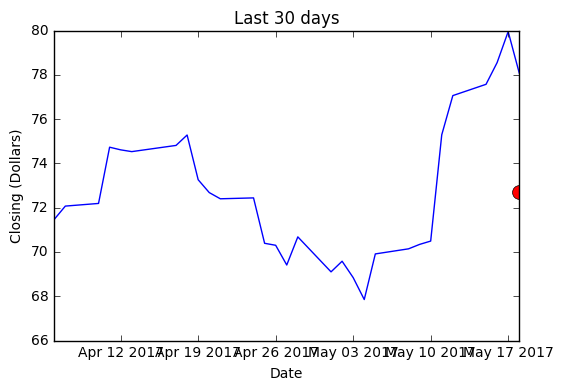

In [156]:
plt.plot(tidy.Date[-30:], tidy.adj_close[-30:])
plt.title('Last 30 days')
plt.xlabel('Date')
plt.ylabel('Closing (Dollars)')
plt.plot(tidy.Date[-1:], tidy.avg_30[-1:],marker = 'o', markersize = 10, color = 'r')

The red dot on the right side of the plot shows the mean of the last 30 days of stock price, as shown in this plot. So when looking at the red plots below, take into consideration that the value corresponding to day 30 actually takes into account the last 30 days. Now that we have added the 30 day moving average and standard deviation to the dataframe and you have a better understanding of what these values mean, lets see how the 30 day moving average compares to RGLD's closing numbers by looking at a plot.

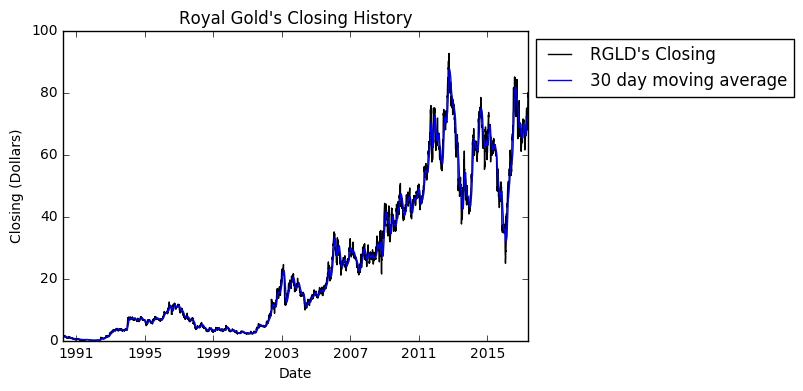

In [157]:
plt.plot(tidy.Date, avg, color = 'black', label = 'RGLD\'s Closing')
plt.title('Royal Gold\'s Closing History')
plt.xlabel('Date')
plt.ylabel('Closing (Dollars)')

plt.plot(tidy.Date[29:], tidy.avg_30[29:], color = 'b', label = '30 day moving average')
plt.legend(loc = 'best', bbox_to_anchor = (1,1))

As you can see, the trailing mean correllates very strongly with the close price of RGLD when looking over a long peroid of time, but let's look at just the past year to-date, February 2016 - April 2017.

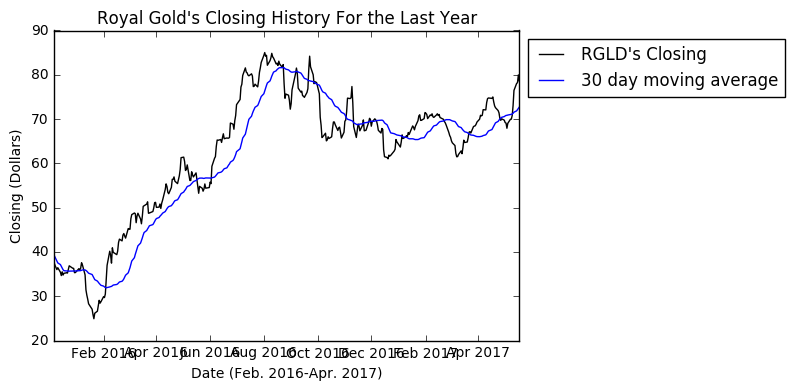

In [158]:
plt.plot(tidy.Date[-365:], avg[-365:], color = 'black', label = 'RGLD\'s Closing')
plt.plot(tidy.Date[-365:], tidy.avg_30[-365:], color = 'b', label = '30 day moving average')
plt.title('Royal Gold\'s Closing History For the Last Year')
plt.xlabel('Date (Feb. 2016-Apr. 2017)')
plt.ylabel('Closing (Dollars)')
plt.legend(loc = 'best', bbox_to_anchor = (1,1))

Above includes the stock price in black and the 30 day rolling mean in blue. The lines are very similar, typically following thesame curve, but there is a bit of variance of when the rolling mean is on top compared to when the stock price is on top. These intersection points can give us valuable insight on the expected trend of the stock price. When the stock price is above the rolling mean, this signifies the stock currently outperforming the last 30 days, which means the crossover point would be a good time to buy the stock. When the rolling mean is above the stock price, the stock is currently underperforming the last 30 days, and an inverstor should sell their shares. 

Now, lets see what happens if we include two trailing means, one 30 days and one 60 days

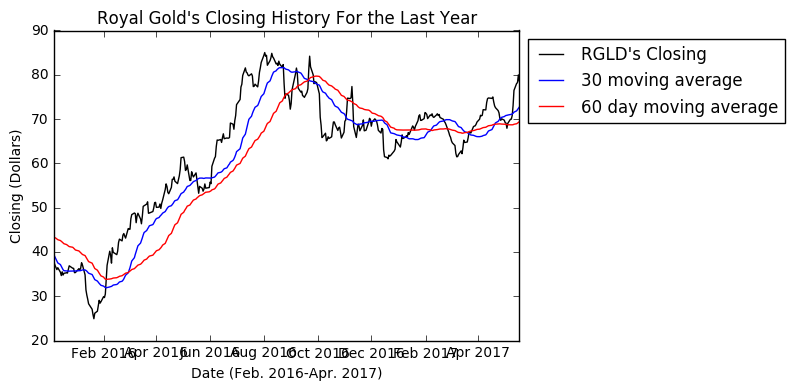

In [159]:
plt.plot(tidy.Date[-365:], avg[-365:], color = 'black', label = 'RGLD\'s Closing')
plt.plot(tidy.Date[-365:], tidy.avg_30[-365:], color = 'b', label = '30 moving average')
plt.plot(tidy.Date[-365:], tidy.avg_60[-365:], color = 'r', label = '60 day moving average')
plt.title('Royal Gold\'s Closing History For the Last Year')
plt.xlabel('Date (Feb. 2016-Apr. 2017)')
plt.ylabel('Closing (Dollars)')
plt.legend(loc = 'best', bbox_to_anchor = (1,1))

Above, the stock price is shown in black. The blue and red lines are the 30 and 60 day rolling means respectively. Since we are using two rolling means, we will ignore the stock price shown in black.  Whenever the blue line is above the red line, this means that short term growth is exceeding that of long term growth, and it is likely a good time to buy at the crossover point. Inversely, whenever the red line is above the   blue linee, it is likely a good time to sell your stock or short the stock, as the short term decline is greater than that of long term. Looking at where the crossover points are, you can see that the stock price tended to follow these rules in this example.

Next, lets see what happens if we include many rolling means and increase the time frame of when we are looking at the stock to 3 years.

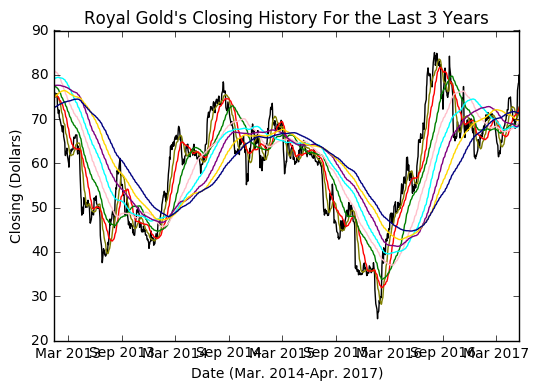

In [160]:
roll15  = avg.rolling(window=15).mean()
roll90  = avg.rolling(window=90).mean()
roll120  = avg.rolling(window=120).mean()
roll150 = avg.rolling(window=150).mean()
roll180  = avg.rolling(window=180).mean()
roll210  = avg.rolling(window=210).mean()


plt.plot(tidy.Date[-1095:], avg[-1095:], color = 'black')
plt.plot(tidy.Date[-1095:], roll15[-1095:], color = 'olive')
plt.plot(tidy.Date[-1095:], tidy.avg_30[-1095:], color = 'red')
plt.plot(tidy.Date[-1095:], tidy.avg_60[-1095:], color = 'green')
plt.plot(tidy.Date[-1095:], roll90[-1095:], color = 'pink')
plt.plot(tidy.Date[-1095:], roll120[-1095:], color = 'cyan')
plt.plot(tidy.Date[-1095:], roll150[-1095:], color = 'purple')
plt.plot(tidy.Date[-1095:], roll180[-1095:], color = 'gold')
plt.plot(tidy.Date[-1095:], roll210[-1095:], color = 'navy')
plt.title('Royal Gold\'s Closing History For the Last 3 Years')
plt.xlabel('Date (Mar. 2014-Apr. 2017)')
plt.ylabel('Closing (Dollars)')

The graph above has a lot going on to it. It is called a moving average ribbon, and much like the other graphs above, shows stock trend. The two lines we will focus on thoguh is the navy and the olive lines, which represent the 15 and 210 day rolling means respectively. Since these rolling means have greatly different windows, it takes a larger change in the stock price to affect the positioning of these lines relative to each other. Whenever the olive line is above the navy line, stock prices are likely rising, and vice versa. Given this large gap between the two, the likelyhood of a false signal of the predicted future market price is very low. However, since the risk is low, the general return is also lower that if, for example, we were looking at the 15 and 30 day rolling means.

Another thing we wanted to explore was which day of the week is the best for stocks/this stock in genereal. To do this we first add and fill a column for the day of the week Mon-Fri(0-4) respectively. We will then calculate the difference between the adjusted opening of one day and the adjusted opening of the next day as a percent relative to the adjuested opening of the first day.
    

In [161]:
dates = tidy.ix[:,0]

dayvals = [] * len(tidy.index)
for d in dates:
    daynum = d.weekday()
    dayvals.append(daynum)


tidy["DoTW"] = dayvals
tidy["adj_diff"] = 0
for i, row in tidy.iterrows():
    if(i < len(tidy.index) - 1):
        tidy.loc[i, 'adj_diff'] = (tidy['adj_open'][i+1] - row.adj_open)/row.adj_open
    #tidy.set_value(i,'adj_diff',(row.adj_open - row.adj_close)/row.adj_open)
tidy.head()

,Date,adj_close,adj_high,adj_low,adj_open,adj_volume,close,ex_dividend,high,low,open,split_ratio,volume,avg_30,avg_60,DoTW,adj_diff
0,1990-03-26,1.139703,1.139703,0.982787,0.982787,4100.0,1.38,0.0,1.38,1.19,1.19,1.0,4100.0,NaN,NaN,0,0.050420
1,1990-03-27,1.139703,1.139703,0.924976,1.032340,3300.0,1.38,0.0,1.38,1.12,1.25,1.0,3300.0,NaN,NaN,1,-0.044437
2,1990-03-28,0.986466,1.085941,0.986466,0.986466,10800.0,1.19,0.0,1.31,1.19,1.19,1.0,10800.0,NaN,NaN,2,0.056103
3,1990-03-29,1.091816,1.150158,0.991803,1.041809,41800.0,1.31,0.0,1.38,1.19,1.25,1.0,41800.0,NaN,NaN,3,-0.054814
4,1990-03-30,1.034352,1.034352,0.984703,0.984703,1500.0,1.25,0.0,1.25,1.19,1.19,1.0,1500.0,NaN,NaN,4,0.157407


Now we want to analyze these changes for each day in order to see which day of the week is best for trading RGLD. 

In [162]:
#we can make a list of all the adjusted differences and put them in a dictonary corresponding to day of the week to
#make it easier to process them
diffs = dict()
diffs[0] = []
diffs[1] = []
diffs[2] = []
diffs[3] = []
diffs[4] = []
for i, row in tidy.iterrows():
    diffs[row.DoTW].append(row.adj_diff)
    
avg_diff = [0]*5
std_dev_diff = [0]*5
for i in range(0,5):
    avg_diff[i] = np.mean(sum(diffs[i])/len(diffs[i]))
    std_dev_diff[i] = np.std(diffs[i])

print('Average differences')
print(avg_diff)
print('Standard deviation of Differences')
print(std_dev_diff)

Average differences
[-0.0012941254976092879, -0.0023235732019440216, 0.0028680525785717741, 0.0061425034949189727, 0.0055155659547473168]
Standard deviation of Differences
[0.054041566749105631, 0.050102659072891013, 0.052249853517149898, 0.055332284647039966, 0.082892318511985821]


Now that we have each days average difference and standard deviation we will conduct a hypothesis test for each day to see if the average is statistically different than the mean in the direction of that averages sign. We will use a significance of alpha = .05 in our tests. So our hypothesis will be as follows:  
  
Day 1 & 2:  
H0(Null): avg_diff = 0 , Ha(alternative):avg_diff < 0  
  
Days 3, 4, and 5:  
H0(Null): avg_diff = 0 , Ha(alternative):avg_diff > 0  
  
Since n is large for each of the averages our test statistics will be $$Z_i = \frac{avg_i}{\frac{s_i}{\sqrt{n_i}}}$$  
So we will now compute these test statistics and get their p-values from the Standard normal curve


In [163]:
Z = [0]*5
for i in range(0,5):
    Z[i] = (avg_diff[i])/(std_dev_diff[i]/(math.sqrt(len(diffs[i]))))
#we will use scipy to get the p Values from these test statistics
p_values = [0]*5
for i in range(0,5):
    p_values[i] = norm.sf(abs(Z[i]))
print("P values")
print(p_values)

P values
[0.19459468624382831, 0.041184902314499054, 0.019889488383773642, 1.89931560562413e-05, 0.0069615499839422845]


From these p values we can see that we reject the null on everyday except for day one with the significance level of .05. This means that we are able to conclude that there is a significant difference when trading during 24-hour time slots based on the day of the week. We can see that on Tuesdays, this stock declines on average since its difference between its adjusted opening price and the adjusted opening price of Wednesday is negative. This means for this stock, RGLD, investing on Tuesday is not a smart idea.  We are also able to say that Wed-Fri the stock does better than average meaning its cost increases during this time peroid. 

## Conclusion

These are just some of the cool analytics you can do with python. Try downloading a different stock's data and see what conclusions you can draw!